In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

In [9]:
def display_training_history(train_history):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_history.history['accuracy'], label='Training Accuracy')
    plt.plot(train_history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_history.history['loss'], label='Training Loss')
    plt.plot(train_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')
    plt.matshow(conf_matrix)
    plt.xticks(range(len(class_names)), class_names)
    plt.yticks(range(len(class_names)), class_names)
    plt.colorbar()
    plt.show()

In [12]:
dataset_paths = {
    'train': 'split/train-00000-of-00001.parquet',
    'validation': 'split/validation-00000-of-00001.parquet',
    'test': 'split/test-00000-of-00001.parquet'
}
train_data = pd.read_parquet("hf://datasets/dair-ai/emotion/" + dataset_paths["train"])

In [15]:
def extract_text_and_labels(dataframe):
    texts = dataframe['text'].tolist()
    tags = dataframe['label'].tolist()
    return texts, tags

In [16]:
train_texts, train_tags = extract_text_and_labels(train_data)

In [17]:
text_tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
text_tokenizer.fit_on_texts(train_texts)
sequence_length = 60
train_sequences = pad_sequences(text_tokenizer.texts_to_sequences(train_texts), maxlen=sequence_length, padding='post')
label_map = {label: idx for idx, label in enumerate(set(train_tags))}
encoded_labels = np.array([label_map[tag] for tag in train_tags])

In [18]:
emotion_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
emotion_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\Agniprabha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
val_data = pd.read_parquet("hf://datasets/dair-ai/emotion/" + dataset_paths["validation"])
val_texts, val_tags = extract_text_and_labels(val_data)
val_sequences = pad_sequences(text_tokenizer.texts_to_sequences(val_texts), maxlen=sequence_length, padding='post')
val_encoded_labels = np.array([label_map[tag] for tag in val_tags])

train_history = emotion_model.fit(
    train_sequences, encoded_labels,
    validation_data=(val_sequences, val_encoded_labels),
    epochs=20
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.3540 - loss: 1.5653 - val_accuracy: 0.6730 - val_loss: 0.9126
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.7503 - loss: 0.7041 - val_accuracy: 0.8195 - val_loss: 0.5546
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8721 - loss: 0.3810 - val_accuracy: 0.8645 - val_loss: 0.4469
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.9278 - loss: 0.2389 - val_accuracy: 0.8680 - val_loss: 0.4185
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.9144 - loss: 0.2672 - val_accuracy: 0.8805 - val_loss: 0.3925
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.9552 - loss: 0.1425 - val_accuracy: 0.8925 - val_loss: 0.3596
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.9690 - loss: 0.1064 - val_accuracy: 0.8965 - val_loss: 0.3684
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - accuracy: 0.9779 - loss: 0.0791 - 

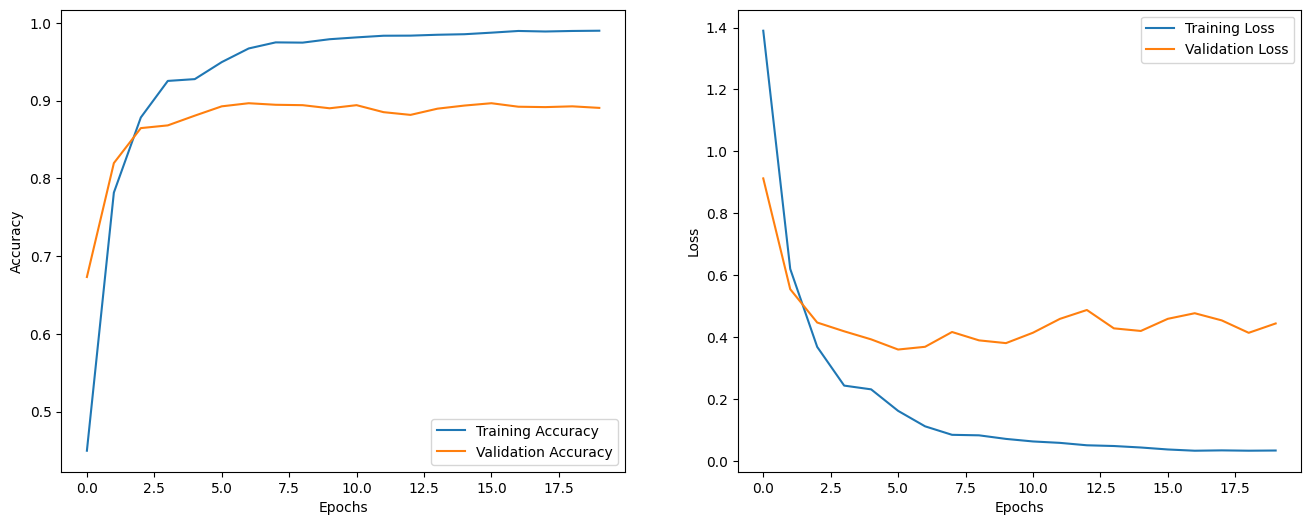

In [20]:
# Display the training history
display_training_history(train_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


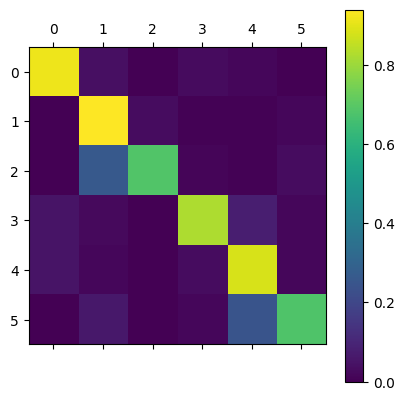

In [21]:
# Prepare and evaluate test data
test_data = pd.read_parquet("hf://datasets/dair-ai/emotion/" + dataset_paths["test"])
test_texts, test_tags = extract_text_and_labels(test_data)
test_sequences = pad_sequences(text_tokenizer.texts_to_sequences(test_texts), maxlen=sequence_length, padding='post')
test_encoded_labels = np.array([label_map[tag] for tag in test_tags])

predictions = np.argmax(emotion_model.predict(test_sequences), axis=-1)
plot_confusion_matrix(test_encoded_labels, predictions, list(label_map.keys()))